# Обучение модели TCN, 1D-CNN

## Импорт библиотек

In [1]:
import pandas as pd, pyarrow
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from pathlib import Path
import re
from datetime import datetime, timedelta
import os, glob, math
import numpy as np
import pandas as pd
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
# --- Настройка путей и sys.path ---
# Добавляем корневую директорию проекта в sys.path для импорта кастомных модулей
PROJECT_ROOT = Path().cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.config import config
from src.logger import logger
from src.database import clickhouse_engine, postgres_engine, ipdr_engine    


Configuration loaded successfully.


2025-10-21 15:20:05,362 | my_logger - INFO - ✅ PostgreSQL engine создан | /data/aturov/scoring/src/database.py:21
2025-10-21 15:20:05,397 | my_logger - INFO - ✅ ClickHouse engine создан | /data/aturov/scoring/src/database.py:36
2025-10-21 15:20:05,398 | my_logger - INFO - ✅ IPDR ClickHouse engine создан | /data/aturov/scoring/src/database.py:46


## Подготовка данных

In [2]:
CURRENT_DATE = '2025-10-21'  # дата формирования датасета

train_df = pd.read_parquet(config.environment.data_processed_path / f'aturov_train_{CURRENT_DATE}.parquet')
logger.info(f"Train shape: {train_df.shape}")
logger.info(f"Train target distribution:\n{train_df['target'].value_counts()}")
val_df = pd.read_parquet(config.environment.data_processed_path / f'aturov_val_{CURRENT_DATE}.parquet')
logger.info(f"Val shape: {val_df.shape}")
logger.info(f"Val target distribution:\n{val_df['target'].value_counts()}")

2025-10-21 15:20:05,476 | my_logger - INFO - Train shape: (27096, 99) | /tmp/ipykernel_3407449/894156377.py:4
2025-10-21 15:20:05,479 | my_logger - INFO - Train target distribution:
target
0    26100
1      996
Name: count, dtype: int64 | /tmp/ipykernel_3407449/894156377.py:5
2025-10-21 15:20:05,495 | my_logger - INFO - Val shape: (8244, 99) | /tmp/ipykernel_3407449/894156377.py:7
2025-10-21 15:20:05,497 | my_logger - INFO - Val target distribution:
target
0    4596
1    3648
Name: count, dtype: int64 | /tmp/ipykernel_3407449/894156377.py:8


In [3]:
# Колонки (из вашего описания)
categorical_cols = [
 'CUST_LEVEL','STATUS','REGION_CELL','PRICE_PLAN_RU','PERIODICITY',
 'PREV_PRICE_PLAN','ORIG_PRICE_PLAN','TRANZ_FLAG','FLAG_4G','IVR_LANG',
 'DEV_TYPE','FLAG_DEVICE_4G','OS_NAME','ACTIVE_IND','REGION','FLAG_ABONKA',
 'MY_BEELINE_USER','BALANCE_USER','MULTIPLAY','M2M_FLAG','GENDER','AGE',
 'match_inn'
]

numeric_cols = [
 'SUBSCRIPTION_FEE','BALANCE_END','REVENUE_ABONKA','USAGE_ABONKA_TP',
 'DAYS_WITHOUT_PAYMENT','TOTAL_RECHARGE','COUNT_RECHARGE','USAGE_NUM_OUT',
 'USAGE_OUT_ONNET_VOICE','USAGE_OUT_OFFNET_VOICE','USAGE_OUT_CITY_VOICE',
 'USAGE_OUT_INT_VOICE','USAGE_OUT_INT_VOICE_RUSSIA','USAGE_IN_ONNET_VOICE',
 'USAGE_IN_OFFNET_VOICE','USAGE_VALUELESS_INTERNET','USAGE_INTERNET',
 'USAGE_INTERNET_2G','USAGE_INTERNET_3G','USAGE_INTERNET_LTE',
 'USAGE_INTERNET_3G_FREE','USAGE_INTERNET_LTE_FREE','USAGE_OUT_OFFNET_O_VOICE',
 'USAGE_OUT_OFFNET_MEGACOM_VOICE','USAGE_IN_OFFNET_O_VOICE',
 'USAGE_IN_OFFNET_MEGACOM_VOICE','COUNT_SMS','REVENUE_VOICE',
 'REVENUE_VOICE_TO_SERVICE','REVENUE_OUT_ONNET_VOICE',
 'REVENUE_OUT_OFFNET_VOICE','REVENUE_OUT_CITY_VOICE',
 'REVENUE_OUT_INT_VOICE','REVENUE_INTERNET_PAYG','USAGE_INTERNET_NIGHT',
 'USAGE_NUM_INTERNET_PAK','USAGE_NUM_OFFNET_PAK','REVENUE_INTERNET_PAK',
 'REVENUE_OFFNET_PAK','INTERCONNECT_MN_IN','INTERCONNECT_MN_OUT',
 'INTERCONNECT_LOC_IN','INTERCONNECT_LOC_OUT','REVENUE_TOTAL_INTERCONNECT',
 'GM','REVENUE_TOTAL','OTHER_CHARGES','USAGE_OUT_FREE_OFFNET_VOICE',
 'REVENUE_DAILY_ABONKA','USAGE_DAILY_ABONKA','REVENUE_ROUMING',
 'USAGE_NUM_INC','REVENUE_OFFNET_O_VOICE','REVENUE_OFFNET_MEGACOM_VOICE',
 'ROLY_VOICE_CHARGE','ROLY_DATA_CHARGE','ROLY_GLOBAL','TOTAL_MOU',
 'LIFETIME_TOTAL','days_from_dt_end_to_date_inactive',
 'days_from_dt_end_to_date_lad','days_from_dt_end_to_price_change_date',
 'days_from_dt_end_to_act_date','days_from_dt_end_to_date_abonka',
 'days_from_dt_end_to_date_contract'
]

id_cols = ['subscription_id','phone_eldik','inn_eldik','id_credit']

In [4]:
seq_col = 'count_weeks'
target_col = 'target'
COUNT_WEEKS = 12  # ожидаем 1..12, где 1 ближе всего к дате выдачи (должен быть последним тайм-степом)
# Базовые проверки
need_cols = set(id_cols + [seq_col, target_col] + categorical_cols + numeric_cols)
missing_train = need_cols - set(train_df.columns)
missing_val   = need_cols - set(val_df.columns)
if missing_train: raise ValueError(f"В train отсутствуют колонки: {missing_train}")
if missing_val:   raise ValueError(f"В val отсутствуют колонки: {missing_val}")


In [5]:
# Кодировщики категориальных (по train)
cat_maps = {}
for col in categorical_cols:
    tr_vals = train_df[col].astype(str).fillna("missing")
    vocab = pd.Index(tr_vals.unique().tolist())
    # 0 — unknown, известные начинаются с 1
    mapping = {v: i+1 for i, v in enumerate(vocab)}
    mapping["unknown"] = 0
    logger.info(f"Категория '{col}': {len(vocab)} уникальных значений (train)")
    # Все пропуски и неизвестные в "missing"
    mapping["missing"] = mapping.get("missing", len(mapping)+1) if "missing" not in mapping else mapping["missing"]
    
    cat_maps[col] = mapping

2025-10-21 15:20:05,522 | my_logger - INFO - Категория 'CUST_LEVEL': 5 уникальных значений (train) | /tmp/ipykernel_3407449/2294425686.py:9
2025-10-21 15:20:05,526 | my_logger - INFO - Категория 'STATUS': 3 уникальных значений (train) | /tmp/ipykernel_3407449/2294425686.py:9
2025-10-21 15:20:05,530 | my_logger - INFO - Категория 'REGION_CELL': 11 уникальных значений (train) | /tmp/ipykernel_3407449/2294425686.py:9
2025-10-21 15:20:05,534 | my_logger - INFO - Категория 'PRICE_PLAN_RU': 107 уникальных значений (train) | /tmp/ipykernel_3407449/2294425686.py:9
2025-10-21 15:20:05,538 | my_logger - INFO - Категория 'PERIODICITY': 6 уникальных значений (train) | /tmp/ipykernel_3407449/2294425686.py:9
2025-10-21 15:20:05,541 | my_logger - INFO - Категория 'PREV_PRICE_PLAN': 149 уникальных значений (train) | /tmp/ipykernel_3407449/2294425686.py:9
2025-10-21 15:20:05,545 | my_logger - INFO - Категория 'ORIG_PRICE_PLAN': 76 уникальных значений (train) | /tmp/ipykernel_3407449/2294425686.py:9
202

In [6]:

def encode_cats(df, maps):
    """ Кодирует категориальные признаки по словарям maps.
        df: pd.DataFrame с данными
        maps: dict, ключ - имя колонки, значение - словарь {категория: индекс}
        Возвращает np.ndarray размерности [F_cat, N], где F_cat - число категориальных признаков,
        N - число объектов (тайм-степов).
    """
    arrs = []
    for col in categorical_cols:
        s = df[col].astype(str).fillna("missing")
        m = maps[col]
        enc = s.map(m).fillna(0).astype(np.int64).to_numpy()
        arrs.append(enc)
    # [F_cat, N] -> [N, F_cat]
    return np.stack(arrs, axis=1).T

In [7]:
# Подготовка последовательностей по id_credit
def build_sequences(df, maps):
    # Сортируем для воспроизводимости
    df = df.sort_values(['id_credit', seq_col])
    Xn_list, Xc_list, y_list, meta_list = [], [], [], []
    grp = df.groupby('id_credit', sort=False)
    for cid, g in grp:
        # Нужны ровно 12 недель: {1,...,12}. Последний тайм-степ — week=1, значит сортируем по убыванию.
        weeks = g[seq_col].dropna().astype(int).tolist()
        if len(g) != COUNT_WEEKS or set(weeks) != set(range(1, COUNT_WEEKS+1)):
            continue
        g = g.sort_values(seq_col, ascending=False)

        num = g[numeric_cols].astype(float).fillna(0.0).to_numpy(dtype=np.float32)                 # [T, F_num]
        cat = []
        for col in categorical_cols:
            s = g[col].astype(str).fillna("missing")
            enc = s.map(maps[col]).fillna(0).astype(np.int64).to_numpy()
            cat.append(enc)
        cat = np.stack(cat, axis=1)                                                                # [T, F_cat]

        yv = int(g[target_col].iloc[0])

        Xn_list.append(num)
        Xc_list.append(cat)
        y_list.append(yv)
        meta_list.append(g[id_cols].iloc[0].to_dict())
    if not Xn_list:
        raise ValueError("После фильтрации нет последовательностей длины 12.")
    Xn = np.stack(Xn_list, axis=0)  # [N, T, F_num]
    Xc = np.stack(Xc_list, axis=0)  # [N, T, F_cat]
    y  = np.array(y_list, dtype=np.int64)
    return Xn, Xc, y, meta_list

Xn_tr, Xc_tr, y_tr, meta_tr = build_sequences(train_df, cat_maps)
Xn_va, Xc_va, y_va, meta_va = build_sequences(val_df,   cat_maps)
print(f"train: Xn {Xn_tr.shape}, Xc {Xc_tr.shape}, y {y_tr.shape}")
print(f"val:   Xn {Xn_va.shape}, Xc {Xc_va.shape}, y {y_va.shape}")
print("class balance (train):", np.unique(y_tr, return_counts=True))

train: Xn (2168, 12, 65), Xc (2168, 12, 23), y (2168,)
val:   Xn (645, 12, 65), Xc (645, 12, 23), y (645,)
class balance (train): (array([0, 1]), array([2087,   81]))


In [8]:
# Нормализация числовых по train
flat = Xn_tr.reshape(-1, Xn_tr.shape[-1])
mu = np.nanmean(flat, axis=0)
std = np.nanstd(flat, axis=0)
std = np.where(std < 1e-6, 1.0, std)

def norm_num(x):
    x = (x - mu) / std
    return np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)

Xn_tr = norm_num(Xn_tr)
Xn_va = norm_num(Xn_va)

In [9]:
# Санитация категорий
Xc_tr = np.nan_to_num(Xc_tr, nan=0).astype(np.int64)
Xc_va = np.nan_to_num(Xc_va, nan=0).astype(np.int64)

In [10]:
# Датасеты
import torch
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SeqDataset(Dataset):
    def __init__(self, Xn, Xc, y):
        self.Xn = torch.tensor(Xn, dtype=torch.float32)
        self.Xc = torch.tensor(Xc, dtype=torch.long)
        self.y  = torch.tensor(y,  dtype=torch.float32)
    def __len__(self): return self.Xn.shape[0]
    def __getitem__(self, i): return self.Xn[i], self.Xc[i], self.y[i]

tr_ds = SeqDataset(Xn_tr, Xc_tr, y_tr)
va_ds = SeqDataset(Xn_va, Xc_va, y_va)

tr_loader = DataLoader(tr_ds, batch_size=256, shuffle=True,  num_workers=0, pin_memory=(device.type=='cuda'))
va_loader = DataLoader(va_ds, batch_size=512, shuffle=False, num_workers=0, pin_memory=(device.type=='cuda'))


In [11]:
import torch.nn.functional as F

def emb_dim(nv): return max(2, min(32, int(math.sqrt(max(nv, 1)))))

F_num = Xn_tr.shape[-1]
cat_cards = [int(max(cat_maps[c].values())) + 1 for c in categorical_cols]

class CNN1DModel(nn.Module):
    def __init__(self, n_num, cat_cards, hidden=128, dropout=0.3):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, emb_dim(c)) for c in cat_cards])
        emb_total = sum(e.embedding_dim for e in self.embs)
        in_ch = n_num + emb_total
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, hidden, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Dropout(dropout)
        )
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x_num, x_cat):
        cat_embs = [emb(x_cat[:, :, i]) for i, emb in enumerate(self.embs)]
        x = torch.cat([x_num] + cat_embs, dim=-1).transpose(1, 2)
        h = self.conv(x)
        return self.fc(h).squeeze(-1)

model = CNN1DModel(F_num, cat_cards, hidden=128, dropout=0.3).to(device)
pos = float((y_tr == 1).sum()); neg = float((y_tr == 0).sum())
pos_weight = torch.tensor(neg / max(pos, 1.0), dtype=torch.float32, device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

In [12]:
# Оценка
def evaluate(loader):
    model.eval()
    losses, ps, ys = [], [], []
    with torch.no_grad():
        for xb_n, xb_c, yb in loader:
            xb_n, xb_c, yb = xb_n.to(device), xb_c.to(device), yb.to(device)
            logits = model(xb_n, xb_c)
            loss = criterion(logits, yb)
            losses.append(float(loss.item()))
            ps.append(torch.sigmoid(logits).cpu().numpy())
            ys.append(yb.cpu().numpy())
    if not ps:
        return float('nan'), float('nan'), float('nan'), float('nan')
    ps = np.concatenate(ps); ys = np.concatenate(ys)
    if len(np.unique(ys)) < 2:
        return np.mean(losses), float('nan'), float('nan'), float('nan')
    auc = roc_auc_score(ys, ps)
    acc = accuracy_score(ys, (ps >= 0.5).astype(int))
    f1 = f1_score(ys, (ps >= 0.5).astype(int))
    return np.mean(losses), auc, acc, f1

# Обучение
epochs = 50
best_auc = -np.inf
best_path = config.environment.model_path / "tcn_best.pt"
patience = 5
pat_cntr = 0

for epoch in range(1, epochs + 1):
    model.train()
    run, cnt = 0.0, 0
    for xb_n, xb_c, yb in tr_loader:
        xb_n, xb_c, yb = xb_n.to(device), xb_c.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb_n, xb_c)
        loss = criterion(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        bs = yb.size(0); run += float(loss.item()) * bs; cnt += bs
    tr_loss = run / max(cnt, 1)

    vl_loss, vl_auc, vl_acc, vl_f1 = evaluate(va_loader)
    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} "
          f"val_loss={vl_loss:.4f} val_auc={vl_auc:.4f} "
          f"val_acc={vl_acc:.4f} val_f1={vl_f1:.4f}")

    if np.isfinite(vl_auc) and vl_auc > best_auc:
        best_auc = vl_auc
        torch.save(model.state_dict(), best_path)
        pat_cntr = 0
    else:
        pat_cntr += 1
        if pat_cntr >= patience:
            print(f"Early stop @epoch {epoch}")
            break

Epoch 01 | train_loss=1.3292 val_loss=11.4374 val_auc=0.6539 val_acc=0.6186 val_f1=0.5341
Epoch 02 | train_loss=1.2900 val_loss=11.5117 val_auc=0.6803 val_acc=0.6512 val_f1=0.5509
Epoch 03 | train_loss=1.2515 val_loss=10.8075 val_auc=0.6927 val_acc=0.6589 val_f1=0.6194
Epoch 04 | train_loss=1.2149 val_loss=9.7456 val_auc=0.6907 val_acc=0.6310 val_f1=0.6316
Epoch 05 | train_loss=1.1639 val_loss=10.5807 val_auc=0.6923 val_acc=0.6667 val_f1=0.6221
Epoch 06 | train_loss=1.1410 val_loss=10.2390 val_auc=0.6843 val_acc=0.6419 val_f1=0.6144
Epoch 07 | train_loss=1.0648 val_loss=10.4942 val_auc=0.6710 val_acc=0.6310 val_f1=0.6020
Epoch 08 | train_loss=1.0193 val_loss=11.9988 val_auc=0.6571 val_acc=0.6140 val_f1=0.5380
Early stop @epoch 8


In [13]:
# Финальная проверка
model.load_state_dict(torch.load(best_path, map_location=device))
vl_loss, vl_auc, vl_acc, vl_f1 = evaluate(va_loader)
print(f"Final(best) | val_loss={vl_loss:.4f} val_auc={vl_auc:.4f} "
      f"val_acc={vl_acc:.4f} val_f1={vl_f1:.4f}")

Final(best) | val_loss=10.8075 val_auc=0.6927 val_acc=0.6589 val_f1=0.6194


Confusion matrix [rows=true 0/1, cols=pred 0/1]:
 [[246 127]
 [ 93 179]]
tn=246 fp=127 fn=93 tp=179
precision=0.5850 recall=0.6581 FPR=0.3405 TPR=0.6581 threshold=0.50
ROC AUC=0.6927 | PR AUC=0.5823


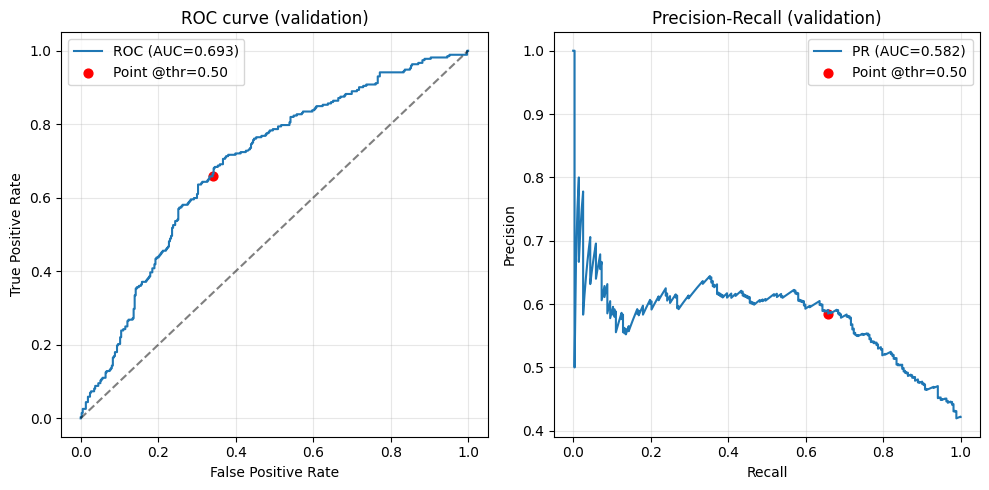

In [14]:
# Матрица ошибок, ROC и PR-кривая
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, average_precision_score

model.eval()
probs_val, ys_val = [], []
with torch.no_grad():
    for xb_n, xb_c, yb in va_loader:
        xb_n, xb_c = xb_n.to(device), xb_c.to(device)
        logits = model(xb_n, xb_c)
        probs_val.append(torch.sigmoid(logits).cpu().numpy())
        ys_val.append(yb.numpy())
probs_val = np.concatenate(probs_val)
ys_val = np.concatenate(ys_val)

thr = best_t if 'best_t' in locals() else 0.5
preds = (probs_val >= thr).astype(int)

cm = confusion_matrix(ys_val, preds, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()
precision = tp / max(tp + fp, 1)
recall = tp / max(tp + fn, 1)
fpr_point = fp / max(fp + tn, 1)
tpr_point = recall
roc_auc = roc_auc_score(ys_val, probs_val)
pr_auc = average_precision_score(ys_val, probs_val)

print("Confusion matrix [rows=true 0/1, cols=pred 0/1]:\n", cm)
print(f"tn={tn} fp={fp} fn={fn} tp={tp}")
print(f"precision={precision:.4f} recall={recall:.4f} FPR={fpr_point:.4f} "
      f"TPR={tpr_point:.4f} threshold={thr:.2f}")
print(f"ROC AUC={roc_auc:.4f} | PR AUC={pr_auc:.4f}")

fpr_arr, tpr_arr, _ = roc_curve(ys_val, probs_val)
prec_arr, rec_arr, _ = precision_recall_curve(ys_val, probs_val)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(fpr_arr, tpr_arr, label=f"ROC (AUC={roc_auc:.3f})")
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].scatter([fpr_point], [tpr_point], color='red', s=40, label=f"Point @thr={thr:.2f}")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC curve (validation)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(rec_arr, prec_arr, label=f"PR (AUC={pr_auc:.3f})")
axes[1].scatter([recall], [precision], color='red', s=40, label=f"Point @thr={thr:.2f}")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall (validation)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()